# Homework 5：高校分群、华东师范大学画像与学科排名预测
本 Notebook 继承 homework_4 的数据成果（已将 ESI 学科数据导入 MySQL，且导出了部分结果 CSV），在此基础上完成以下任务：
- 任务 8：结合学科排名数据，对全球高校进行分群；并检索与华东师范大学（ECNU）相似的高校。
- 任务 9：通过探索性分析，为华东师范大学构建“学科画像”。
- 任务 10：利用数据建模方式，对各学科构建排名预测模型，并评估效果。

运行前准备：
- 请在当前目录（homework_5/）放置数据库连接配置文件 `config.json`（包含 MySQL 连接信息）。
- 推荐先安装依赖：`pip install pandas numpy matplotlib seaborn scikit-learn sqlalchemy pymysql joblib pyarrow`。

## 1. 连接数据库并加载ESI数据到DataFrame
本节将从当前目录 `./config.json` 读取连接信息，连接 MySQL 并载入表 `esi_data` 的核心字段到 pandas。为了加快多次运行，首次读取后会缓存为 feather/parquet 文件，后续优先从缓存加载。

In [19]:
# 基础导入与缓存路径
import os, json, math, pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr
import joblib
CACHE_DIR = pathlib.Path("results/cache")
CACHE_DIR.mkdir(parents=True, exist_ok=True)
DATA_FIELDS = [
    "subject_rank","institution","country_region","web_of_science_documents","cites","cites_per_paper","top_papers","filter_value",
]

def load_db_config():
    """只从当前工作目录读取 ./config.json，找到即加载并打印路径。"""
    p = (pathlib.Path.cwd() / "config.json").resolve()
    if p.exists():
        print(f"Using config: {p}")
        with open(p, "r", encoding="utf-8") as f:
            return json.load(f)
    raise FileNotFoundError("未找到配置文件。请将 config.json 放在当前工作目录（homework_5/）下。")

def get_engine(cfg):
    user = cfg["mysql_user"]; pwd = cfg["mysql_password"]; host = cfg["mysql_host"]; db = cfg["mysql_db"]
    url = f"mysql+pymysql://{user}:{pwd}@{host}/{db}?charset=utf8mb4"
    return create_engine(url)

def load_esi_dataframe(force_reload=False):
    feather_path = CACHE_DIR/"esi_data.feather"
    parquet_path = CACHE_DIR/"esi_data.parquet"
    if not force_reload and (feather_path.exists() or parquet_path.exists()):
        try:
            if feather_path.exists():
                return pd.read_feather(feather_path)
            else:
                return pd.read_parquet(parquet_path)
        except Exception:
            pass
    cfg = load_db_config()
    engine = get_engine(cfg)
    sql = "SELECT " + ",".join(DATA_FIELDS) + " FROM esi_data"
    df = pd.read_sql(sql, engine)
    # 缓存：优先 feather（需要 pyarrow），失败则退回 parquet（pyarrow/fastparquet）
    try:
        df.reset_index(drop=True).to_feather(feather_path)
    except Exception:
        try:
            df.to_parquet(parquet_path, index=False)
        except Exception:
            # 如果既没有 pyarrow 也没有 fastparquet，就直接跳过缓存
            pass
    return df

df = load_esi_dataframe(force_reload=False)
display(df.head(), df.shape)

Using config: C:\coding\season2.1\data\homework_5\config.json


,subject_rank,institution,country_region,web_of_science_documents,cites,cites_per_paper,top_papers,filter_value
0,1,CHINESE ACADEMY OF SCIENCES,CHINA MAINLAND,15661,332254,21.22,251,AGRICULTURAL SCIENCES
1,2,CHINESE ACADEMY OF AGRICULTURAL SCIENCES,CHINA MAINLAND,12222,223855,18.32,198,AGRICULTURAL SCIENCES
2,3,UNITED STATES DEPARTMENT OF AGRICULTURE (USDA),USA,12564,220644,17.56,105,AGRICULTURAL SCIENCES
3,4,CHINA AGRICULTURAL UNIVERSITY,CHINA MAINLAND,10052,207779,20.67,166,AGRICULTURAL SCIENCES
4,5,INRAE,FRANCE,9314,187838,20.17,118,AGRICULTURAL SCIENCES


(34121, 8)

## 2. 数据检查、清洗与字段标准化
- 去重、空值检查与基本填充；
- 文本字段规范化（去两端空白、统一大小写策略）；
- 数值字段类型转换；
- 每学科计算 `max_rank` 与 `rank_percentile = (rank-1)/(max_rank-1)`。

In [20]:
def clean_and_enrich(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    # 去重
    d = d.drop_duplicates()
    # 文本标准化
    for col in ["institution", "country_region", "filter_value"]:
        if col in d.columns:
            d[col] = d[col].astype(str).str.strip()
            # 保持原有大小写，但空字符串填为 UNKNOWN（国家/地区）；院校可保留空值以便后续剔除
    # 注意：上面已将 None/NaN 转成字符串 'None'/'nan'，因此这里用字符串替换
    d["country_region"] = d["country_region"].replace(["", "nan", "None"], "UNKNOWN")
    # 数值字段类型
    for col in ["subject_rank","web_of_science_documents","cites","top_papers"]:
        if col in d.columns:
            d[col] = pd.to_numeric(d[col], errors="coerce")
    if "cites_per_paper" in d.columns:
        d["cites_per_paper"] = pd.to_numeric(d["cites_per_paper"], errors="coerce")
    # 删除缺少关键字段的行
    d = d.dropna(subset=["subject_rank", "institution", "filter_value"])
    # 计算每学科的 max_rank
    d["max_rank"] = d.groupby("filter_value")["subject_rank"].transform("max")
    # 防止分母为0
    d["rank_percentile"] = (d["subject_rank"] - 1) / (d["max_rank"].replace(1, np.nan) - 1)
    d["rank_percentile"] = d["rank_percentile"].fillna(0.0).clip(0, 1)
    return d
df_clean = clean_and_enrich(df)
display(df_clean.head(), df_clean.isna().sum())

,subject_rank,institution,country_region,web_of_science_documents,cites,cites_per_paper,top_papers,filter_value,max_rank,rank_percentile
0,1,CHINESE ACADEMY OF SCIENCES,CHINA MAINLAND,15661,332254,21.22,251,AGRICULTURAL SCIENCES,1381,0.000000
1,2,CHINESE ACADEMY OF AGRICULTURAL SCIENCES,CHINA MAINLAND,12222,223855,18.32,198,AGRICULTURAL SCIENCES,1381,0.000725
2,3,UNITED STATES DEPARTMENT OF AGRICULTURE (USDA),USA,12564,220644,17.56,105,AGRICULTURAL SCIENCES,1381,0.001449
3,4,CHINA AGRICULTURAL UNIVERSITY,CHINA MAINLAND,10052,207779,20.67,166,AGRICULTURAL SCIENCES,1381,0.002174
4,5,INRAE,FRANCE,9314,187838,20.17,118,AGRICULTURAL SCIENCES,1381,0.002899


subject_rank                0
institution                 0
country_region              0
web_of_science_documents    0
cites                       0
cites_per_paper             0
top_papers                  0
filter_value                0
max_rank                    0
rank_percentile             0
dtype: int64

## 3. 构建高校×学科特征矩阵与标准化
- 以 institution 为行、filter_value 为列构建多组特征：
  - rank_percentile（缺失填 1.0，越小越好）；
  - cites_per_paper 的 z 分数（按学科标准化）；
  - top_papers_rate：top_papers 在学科内的归一化占比。
- 合并三组特征，并整体做 StandardScaler。

In [21]:
def build_feature_matrices(d: pd.DataFrame):
    # rank_percentile pivot
    mat_rank = d.pivot_table(index="institution", columns="filter_value", values="rank_percentile", aggfunc="min")
    mat_rank = mat_rank.fillna(1.0)
    # cites_per_paper -> zscore within subject
    d_cp = d.copy()
    d_cp["cpp_z"] = d_cp.groupby("filter_value")["cites_per_paper"].transform(lambda x: (x - x.mean())/x.std(ddof=0) if x.std(ddof=0) not in [0, np.nan] else 0)
    mat_cpp = d_cp.pivot_table(index="institution", columns="filter_value", values="cpp_z", aggfunc="mean").fillna(0.0)
    # top_papers rate within subject
    d_tp = d.copy()
    d_tp["tp_rate"] = d_tp["top_papers"] / d_tp.groupby("filter_value")["top_papers"].transform("max")
    d_tp["tp_rate"] = d_tp["tp_rate"].replace([np.inf, -np.inf], np.nan).fillna(0.0).clip(0, 1)
    mat_tp = d_tp.pivot_table(index="institution", columns="filter_value", values="tp_rate", aggfunc="mean").fillna(0.0)
    # 对三块特征做列名前缀
    mat_rank.columns = pd.MultiIndex.from_product([["rank"], mat_rank.columns])
    mat_cpp.columns = pd.MultiIndex.from_product([["cppz"], mat_cpp.columns])
    mat_tp.columns = pd.MultiIndex.from_product([["tpr"], mat_tp.columns])
    # 合并
    mat = pd.concat([mat_rank, mat_cpp, mat_tp], axis=1).sort_index(axis=1)
    # 标准化
    scaler = StandardScaler(with_mean=True, with_std=True)
    mat_std = pd.DataFrame(scaler.fit_transform(mat.fillna(0.0)), index=mat.index, columns=mat.columns)
    return mat, mat_std, scaler
mat, mat_std, scaler = build_feature_matrices(df_clean)
display(mat.shape, mat_std.shape)

(9990, 66)

(9990, 66)

## 4. 全局高校聚类分群与簇数选择
- 尝试 KMeans(k=3..12)，评估轮廓系数与 Calinski-Harabasz 指标，选择较优 k；
- 固定 random_state 确保复现；
- 为每所高校赋予 cluster 标签并保存。

In [22]:
def kmeans_cluster_search(X: pd.DataFrame, k_range=range(3, 13), random_state=42):
    metrics = []
    best = None
    for k in k_range:
        km = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        labels = km.fit_predict(X)
        try:
            sil = silhouette_score(X, labels)
        except Exception:
            sil = np.nan
        try:
            ch = calinski_harabasz_score(X, labels)
        except Exception:
            ch = np.nan
        metrics.append({"k": k, "silhouette": sil, "calinski_harabasz": ch})
        if best is None or (not np.isnan(sil) and sil > best["silhouette"]):
            best = {"k": k, "silhouette": sil, "calinski_harabasz": ch, "model": km, "labels": labels}
    return pd.DataFrame(metrics), best
metrics_df, best = kmeans_cluster_search(mat_std, k_range=range(3, 13), random_state=42)
display(metrics_df.sort_values(["silhouette","calinski_harabasz"], ascending=[False, False]).head(5))
cluster_k = best["k"] if isinstance(best, dict) else 5
cluster_labels = best["labels"] if isinstance(best, dict) else KMeans(n_clusters=cluster_k, random_state=42).fit_predict(mat_std)
inst_cluster = pd.DataFrame({"institution": mat_std.index, "cluster": cluster_labels}).set_index("institution")
inst_cluster.to_csv("results/institution_clusters.csv", index=True)
display(inst_cluster['cluster'].value_counts().sort_index())

,k,silhouette,calinski_harabasz
0,3,0.647174,1984.340888
1,4,0.620853,1548.677010
3,6,0.494878,1141.267901
5,8,0.488086,935.897679
2,5,0.487309,1301.036186


cluster
0    9215
1      90
2     685
Name: count, dtype: int64

## 5. 分群可视化与簇特征解读
- 使用 PCA/t-SNE/UMAP 将高校降至2D，着色为 cluster；
- 各簇的学科均值热力图并标注强项；
- 导出簇清单与统计。

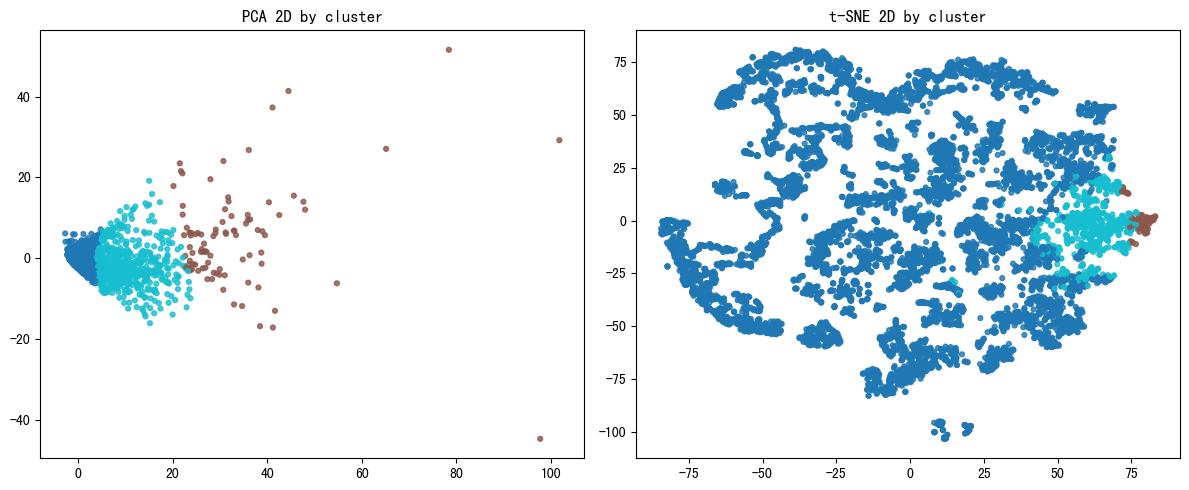

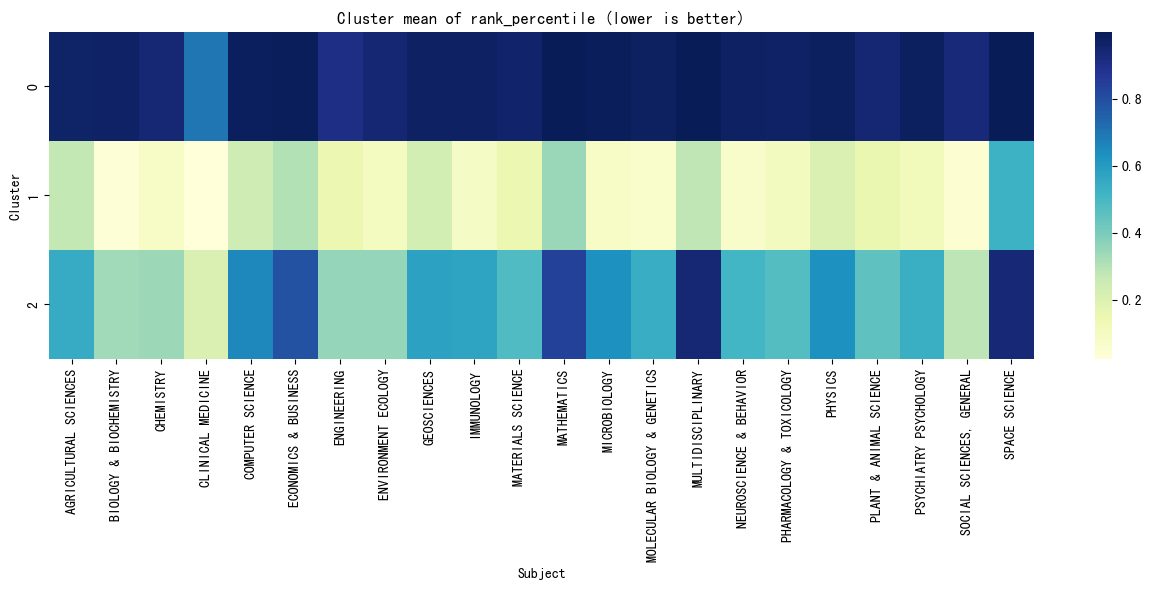

In [23]:
from sklearn.manifold import TSNE
def visualize_clusters(X: pd.DataFrame, labels: np.ndarray):
    pca2 = PCA(n_components=2, random_state=42).fit_transform(X)
    tsne2 = TSNE(n_components=2, random_state=42, init='random', learning_rate='auto').fit_transform(X)
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    axes[0].scatter(pca2[:,0], pca2[:,1], c=labels, cmap='tab10', s=12, alpha=0.8)
    axes[0].set_title('PCA 2D by cluster')
    axes[1].scatter(tsne2[:,0], tsne2[:,1], c=labels, cmap='tab10', s=12, alpha=0.8)
    axes[1].set_title('t-SNE 2D by cluster')
    plt.tight_layout()
    plt.show()
visualize_clusters(mat_std.values, inst_cluster.loc[mat_std.index, 'cluster'].values)
# 各簇在学科上的 rank_percentile 均值热力图
rank_cols = [c for c in mat.columns if isinstance(c, tuple) and c[0]=='rank']
rank_mat = mat[rank_cols].copy()
rank_mat.columns = [c[1] for c in rank_mat.columns]
clustered_rank_mean = rank_mat.groupby(inst_cluster.loc[rank_mat.index, 'cluster']).mean()
plt.figure(figsize=(min(18, 2+0.5*len(clustered_rank_mean.columns)), 6))
sns.heatmap(clustered_rank_mean, cmap='YlGnBu', cbar=True)
plt.title('Cluster mean of rank_percentile (lower is better)')
plt.xlabel('Subject')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()
# 导出
inst_cluster.reset_index().to_csv('results/institution_clusters.csv', index=False)
clustered_rank_mean.to_csv('results/cluster_rank_percentile_mean.csv')

## 6. 与华东师范大学相似高校检索（最近邻）
- 在标准化特征空间用余弦相似度检索最近邻；
- 支持排除同校、限制同国家等过滤；
- 导出相似高校清单。

In [24]:
def find_similar_institutions(target="EAST CHINA NORMAL UNIVERSITY", n_neighbors=10, exclude_same=True, same_country_only=False):
    X = mat_std.loc[:, :].values
    names = mat_std.index.tolist()
    nn = NearestNeighbors(metric='cosine', n_neighbors=min(n_neighbors+1, len(names)))
    nn.fit(X)
    if target not in names:
        print(f"未找到高校：{target}")
        return pd.DataFrame()
    idx = names.index(target)
    dists, idxs = nn.kneighbors(X[idx:idx+1], return_distance=True)
    pairs = []
    for dist, j in zip(dists[0], idxs[0]):
        inst = names[j]
        if exclude_same and inst == target:
            continue
        pairs.append((inst, 1.0 - dist))  # 余弦相似度 = 1 - 距离
    out = pd.DataFrame(pairs, columns=["institution", "cosine_similarity"])
    out["cluster"] = inst_cluster.loc[out["institution"], "cluster"].values
    # 可选过滤：同国家
    if same_country_only:
        # 用 df_clean 中 institution->country_region 的众数
        cr_map = df_clean.groupby("institution")["country_region"].agg(lambda x: x.mode().iat[0] if not x.mode().empty else x.iloc[0])
        tgt_country = cr_map.get(target, None)
        if tgt_country is not None:
            out = out[out["institution"].map(cr_map) == tgt_country]
    out = out.sort_values("cosine_similarity", ascending=False).head(n_neighbors)
    out.to_csv("results/similar_to_ECNU.csv", index=False)
    display(out)
    return out
_ = find_similar_institutions("EAST CHINA NORMAL UNIVERSITY", n_neighbors=15)

,institution,cosine_similarity,cluster
0,NANJING NORMAL UNIVERSITY,0.889943,2
1,BEIJING NORMAL UNIVERSITY,0.867665,2
2,UNIVERSITY OF VICTORIA,0.858124,2
3,TECHNICAL UNIVERSITY OF BERLIN,0.845337,2
4,LANZHOU UNIVERSITY,0.835177,2
5,GUANGZHOU UNIVERSITY,0.834240,2
6,SOUTH CHINA NORMAL UNIVERSITY,0.832951,2
7,NORWEGIAN UNIVERSITY OF SCIENCE & TECHNOLOGY (...,0.824745,2
8,SOUTHWEST UNIVERSITY - CHINA,0.824578,2
9,UNIVERSITY OF WATERLOO,0.816400,2


## 7. 华东师范大学学科画像（统计与可视化）
- 指标：rank_percentile 分布、Top x% 学科数量、学科覆盖面；
- 与全局/同簇均值对比；
- 可视化：条形图、雷达图、热力图。

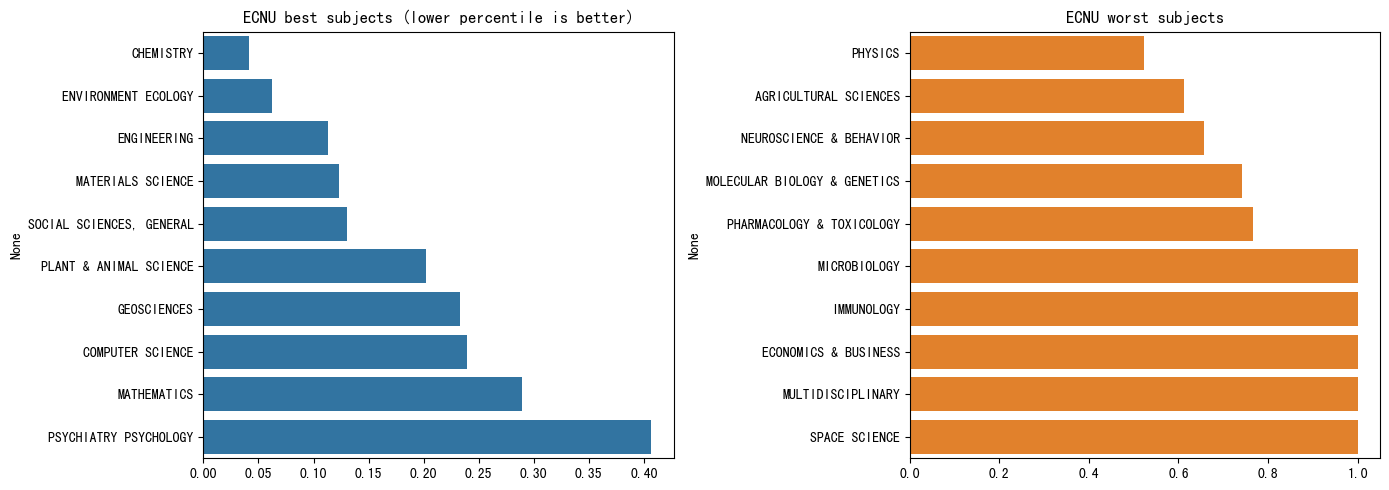

{'summary': {'subject_coverage': 17, 'top_pct': 0.2, 'top_subject_count': 5},
 'top_subjects': ['CHEMISTRY',
  'ENGINEERING',
  'ENVIRONMENT ECOLOGY',
  'MATERIALS SCIENCE',
  'SOCIAL SCIENCES, GENERAL'],
 'compare':                                   ECNU  GlobalMean  ClusterMean
 AGRICULTURAL SCIENCES         0.611594    0.930876     0.547769
 BIOLOGY & BIOCHEMISTRY        0.436893    0.917464     0.335253
 CHEMISTRY                     0.041589    0.892840     0.344692
 CLINICAL MEDICINE             0.422183    0.661599     0.208781
 COMPUTER SCIENCE              0.238979    0.956803     0.656165
 ECONOMICS & BUSINESS          1.000000    0.972820     0.786546
 ENGINEERING                   0.113465    0.860554     0.353161
 ENVIRONMENT ECOLOGY           0.062470    0.896593     0.353028
 GEOSCIENCES                   0.233390    0.941189     0.581468
 IMMUNOLOGY                    1.000000    0.941188     0.576203
 MATERIALS SCIENCE             0.123496    0.920919     0.485064
 MAT

In [25]:
def ecnu_profile(target="EAST CHINA NORMAL UNIVERSITY", top_pct=0.2):
    if target not in mat.index:
        print("目标高校不在样本中")
        return None
    # 取该校的 rank_percentile 向量
    rank_cols = [c for c in mat.columns if isinstance(c, tuple) and c[0]=="rank"]
    r = mat.loc[target, rank_cols]
    r.index = [c[1] for c in r.index]
    # 统计 Top x% 学科数量（rank_percentile <= top_pct）
    top_mask = (r <= top_pct)
    top_subjects = r.index[top_mask].tolist()
    summary = {
        "subject_coverage": int((r < 1.0).sum()),
        "top_pct": top_pct,
        "top_subject_count": int(top_mask.sum()),
    }
    # 与全局/同簇均值对比
    cl = int(inst_cluster.loc[target, "cluster"])
    global_mean = mat[rank_cols].mean()
    cluster_mean = mat.groupby(inst_cluster["cluster"])[rank_cols].mean().loc[cl]
    cluster_mean.index = [c[1] for c in cluster_mean.index]
    g = pd.DataFrame({"ECNU": r, "GlobalMean": global_mean.values, "ClusterMean": cluster_mean.values}, index=r.index)
    # 可视化条形图（最强和最弱各若干）
    best = r.sort_values().head(10)
    worst = r.sort_values().tail(10)
    fig, axes = plt.subplots(1,2, figsize=(14,5))
    sns.barplot(x=best.values, y=best.index, ax=axes[0], color='C0')
    axes[0].set_title('ECNU best subjects (lower percentile is better)')
    sns.barplot(x=worst.values, y=worst.index, ax=axes[1], color='C1')
    axes[1].set_title('ECNU worst subjects')
    plt.tight_layout(); plt.show()
    g.to_csv("results/ecnu_subject_profile_compare.csv")
    return {"summary": summary, "top_subjects": top_subjects, "compare": g}
ecnu_stats = ecnu_profile("EAST CHINA NORMAL UNIVERSITY", top_pct=0.2)
ecnu_stats

## 8. 学科排名预测任务与特征工程
- 以每个学科为子任务；目标 y=subject_rank，同时计算 y_percentile 以供参考；
- 数值特征（对数化）：log_documents, log_cites, cites_per_paper, top_papers_rate；
- 类别特征：country_region One-Hot；
- 注意：不泄漏目标（特征仅使用与 rank 同期的统计）。

In [26]:
def make_subject_features(d: pd.DataFrame):
    d = d.copy()
    d["log_documents"] = np.log1p(d["web_of_science_documents"])
    d["log_cites"] = np.log1p(d["cites"])
    d["tp_rate"] = d["top_papers"] / d.groupby("filter_value")["top_papers"].transform("max")
    d["tp_rate"] = d["tp_rate"].replace([np.inf, -np.inf], np.nan).fillna(0.0).clip(0,1)
    # y 与 y_percentile
    d["y"] = d["subject_rank"].astype(float)
    d["y_percentile"] = d["rank_percentile"].astype(float)
    return d
df_feat = make_subject_features(df_clean)
display(df_feat.head())

,subject_rank,institution,country_region,web_of_science_documents,cites,cites_per_paper,top_papers,filter_value,max_rank,rank_percentile,log_documents,log_cites,tp_rate,y,y_percentile
0,1,CHINESE ACADEMY OF SCIENCES,CHINA MAINLAND,15661,332254,21.22,251,AGRICULTURAL SCIENCES,1381,0.000000,9.658993,12.713658,1.000000,1.0,0.000000
1,2,CHINESE ACADEMY OF AGRICULTURAL SCIENCES,CHINA MAINLAND,12222,223855,18.32,198,AGRICULTURAL SCIENCES,1381,0.000725,9.411075,12.318758,0.788845,2.0,0.000725
2,3,UNITED STATES DEPARTMENT OF AGRICULTURE (USDA),USA,12564,220644,17.56,105,AGRICULTURAL SCIENCES,1381,0.001449,9.438670,12.304310,0.418327,3.0,0.001449
3,4,CHINA AGRICULTURAL UNIVERSITY,CHINA MAINLAND,10052,207779,20.67,166,AGRICULTURAL SCIENCES,1381,0.002174,9.215626,12.244235,0.661355,4.0,0.002174
4,5,INRAE,FRANCE,9314,187838,20.17,118,AGRICULTURAL SCIENCES,1381,0.002899,9.139381,12.143340,0.470120,5.0,0.002899


## 9. 数据集划分（按学科打乱，前60%训练、后20%测试）
- 对每个学科打乱并切分：60% 训练、20% 验证（可选）、20% 测试；
- 记录每个学科的样本大小。

In [27]:
from math import floor, ceil
def per_subject_split(d: pd.DataFrame, random_state=42):
    splits = {}
    for subject, sdf in d.groupby("filter_value"):
        sdf = sdf.sample(frac=1.0, random_state=random_state).reset_index(drop=True)
        n = len(sdf)
        if n < 5:
            continue
        n_train = floor(0.6*n)
        n_test = ceil(0.2*n)
        idx_train = sdf.index[:n_train]
        idx_test = sdf.index[-n_test:]
        idx_val = sdf.index[n_train:n - n_test]  # 可选验证集
        splits[subject] = {
            "train": sdf.loc[idx_train],
            "val": sdf.loc[idx_val],
            "test": sdf.loc[idx_test],
        }
    return splits
splits = per_subject_split(df_feat, random_state=42)
{k: {kk: len(vv) for kk, vv in v.items()} for k, v in list(splits.items())[:5]}

{'AGRICULTURAL SCIENCES': {'train': 828, 'val': 276, 'test': 277},
 'BIOLOGY & BIOCHEMISTRY': {'train': 989, 'val': 330, 'test': 330},
 'CHEMISTRY': {'train': 1284, 'val': 428, 'test': 429},
 'CLINICAL MEDICINE': {'train': 4052, 'val': 1351, 'test': 1351},
 'COMPUTER SCIENCE': {'train': 517, 'val': 173, 'test': 173}}

## 10. 模型训练（基线与树模型）
- 构建 sklearn Pipeline：数值特征标准化 + 模型；
- 基线：DummyRegressor(strategy='median')；
- 主模型：RandomForestRegressor 与 HistGradientBoostingRegressor；
- 每个学科独立训练并返回模型与评估结果。

In [29]:
def train_model_for_subject(sdf: pd.DataFrame, model_name="rf", random_state=42):
    num_features = ["log_documents","log_cites","cites_per_paper","tp_rate"]
    cat_features = ["country_region"]
    X = sdf[num_features + cat_features]
    y = sdf["y"]
    pre = ColumnTransformer([
        ("num", Pipeline([("scaler", StandardScaler())]), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ])
    if model_name == "rf":
        model = RandomForestRegressor(n_estimators=300, random_state=random_state, n_jobs=-1)
    elif model_name == "hgb":
        model = HistGradientBoostingRegressor(random_state=random_state)
    else:
        return {"error": f"unknown model {model_name}"}
    pipe = Pipeline([("pre", pre), ("model", model)])
    return pipe.fit(X, y)

def evaluate_model(pipe, sdf_test: pd.DataFrame):
    Xtest = sdf_test[["log_documents","log_cites","cites_per_paper","tp_rate","country_region"]]
    ytest = sdf_test["y"].values
    yhat = pipe.predict(Xtest)
    mae = mean_absolute_error(ytest, yhat)
    # 兼容旧版 sklearn：手动计算 RMSE
    mse = mean_squared_error(ytest, yhat)
    rmse = float(mse ** 0.5)
    try:
        rho, _ = spearmanr(ytest, yhat)
    except Exception:
        rho = np.nan
    return {"MAE": mae, "RMSE": rmse, "Spearman": rho, "yhat": yhat}

def per_subject_train_evaluate(splits, model_name="rf"):
    records = []
    models = {}
    for subject, part in splits.items():
        if len(part["train"]) < 20 or len(part["test"]) < 10:
            continue
        pipe = train_model_for_subject(part["train"], model_name=model_name)
        metrics = evaluate_model(pipe, part["test"])
        models[subject] = pipe
        rec = {"subject": subject, "model": model_name, **{k:v for k,v in metrics.items() if k!="yhat"}, "n_train": len(part["train"]), "n_test": len(part["test"]) }
        records.append(rec)
    df_scores = pd.DataFrame(records).sort_values(["Spearman","MAE"], ascending=[False, True])
    return models, df_scores

models_rf, scores_rf = per_subject_train_evaluate(splits, model_name="rf")
display(scores_rf.head())
scores_rf.to_csv("results/subject_rank_model_scores_rf.csv", index=False)

,subject,model,MAE,RMSE,Spearman,n_train,n_test
3,CLINICAL MEDICINE,rf,1.234870,1.666935,1.000000,4052,1351
6,ENGINEERING,rf,1.331691,1.659040,0.999997,1672,558
20,"SOCIAL SCIENCES, GENERAL",rf,1.358437,1.706626,0.999997,1444,482
2,CHEMISTRY,rf,1.492673,1.895662,0.999995,1284,429
1,BIOLOGY & BIOCHEMISTRY,rf,1.574061,1.928111,0.999994,989,330


## 11. 模型评估（MAE/RMSE/相关性）与可视化
- 绘制 y vs yhat 散点与残差直方图；
- 输出单学科与总体加权平均指标。

{'MAE': 1.5286281588447668,
 'RMSE': 1.977305850797313,
 'Spearman': np.float64(0.9999853201726798)}

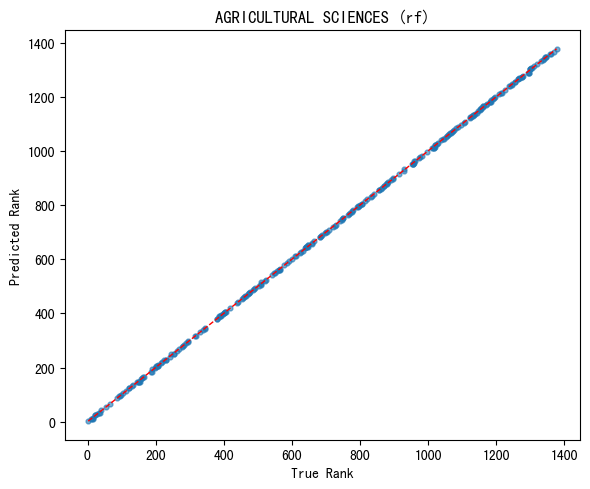

In [30]:
def plot_pred_vs_true(sdf_test: pd.DataFrame, yhat: np.ndarray, title=""):
    y = sdf_test["y"].values
    plt.figure(figsize=(6,5))
    plt.scatter(y, yhat, s=12, alpha=0.6)
    lim = [min(y.min(), yhat.min()), max(y.max(), yhat.max())]
    plt.plot(lim, lim, 'r--', lw=1)
    plt.xlabel('True Rank')
    plt.ylabel('Predicted Rank')
    plt.title(title)
    plt.tight_layout(); plt.show()
def evaluate_one_subject_example(subject_any: str, model_name='rf'):
    part = splits.get(subject_any)
    if not part:
        print('无该学科或样本过少')
        return
    pipe = train_model_for_subject(part['train'], model_name=model_name)
    metrics = evaluate_model(pipe, part['test'])
    display({k: v for k, v in metrics.items() if k != 'yhat'})
    plot_pred_vs_true(part['test'], metrics['yhat'], title=f'{subject_any} ({model_name})')
    return metrics
example_subject = next(iter(splits.keys())) if len(splits)>0 else None
if example_subject:
    _ = evaluate_one_subject_example(example_subject, model_name='rf')

## 12. 误差分析与特征重要性
- 输出 feature_importances_（树模型）；
- 列出 Top-K 最大误差样本；
- 可选做 permutation importance 或 SHAP。

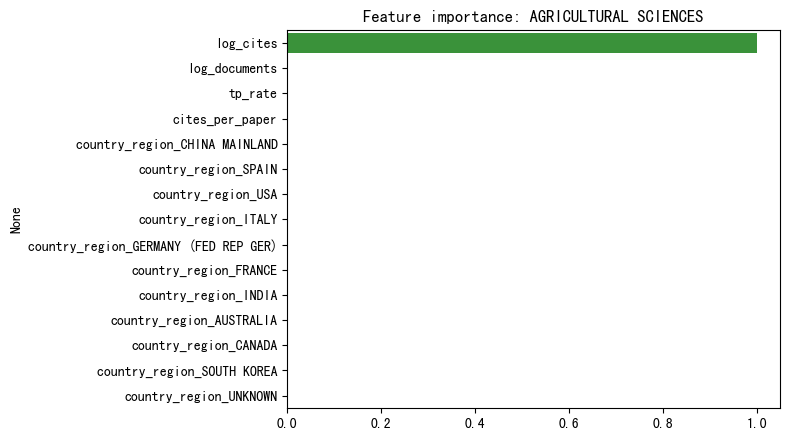

In [31]:
def feature_importance_example(subject_any: str, model_name='rf', topk=15):
    part = splits.get(subject_any)
    if not part:
        print('无该学科或样本过少')
        return
    pipe = train_model_for_subject(part['train'], model_name=model_name)
    # 仅对树模型展示 importance
    model = pipe.named_steps['model']
    if hasattr(model, 'feature_importances_'):
        pre = pipe.named_steps['pre']
        ohe = pre.named_transformers_['cat']
        num_names = ["log_documents","log_cites","cites_per_paper","tp_rate"]
        cat_names = list(ohe.get_feature_names_out(["country_region"]))
        feat_names = num_names + cat_names
        importances = model.feature_importances_
        imp = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(topk)
        plt.figure(figsize=(8, max(4, 0.3*len(imp))))
        sns.barplot(x=imp.values, y=imp.index, color='C2')
        plt.title(f'Feature importance: {subject_any}')
        plt.tight_layout(); plt.show()
        return imp
    else:
        print('该模型不支持 feature_importances_')
        return None
if example_subject:
    _ = feature_importance_example(example_subject, model_name='rf')

## 13. 超参数搜索与交叉验证（可选）
- 以 RandomizedSearchCV 对若干学科进行 5 折交叉验证；
- 评分以负 MAE 为主，控制搜索规模。

In [34]:
from sklearn.model_selection import RandomizedSearchCV
from joblib import parallel_backend

def hyperparam_search_for_subject(subject_any: str, n_iter=10, random_state=42):
    part = splits.get(subject_any)
    if not part:
        print('无该学科或样本过少')
        return None, None

    # 为 joblib 指定 ASCII 安全的临时目录，避免 Windows 下非 ASCII 路径导致的 UnicodeEncodeError
    tmp_dir = pathlib.Path('results/joblib_tmp').resolve()
    tmp_dir.mkdir(parents=True, exist_ok=True)
    os.environ['JOBLIB_TEMP_FOLDER'] = str(tmp_dir)

    num_features = ["log_documents","log_cites","cites_per_paper","tp_rate"]
    cat_features = ["country_region"]
    Xtr = part['train'][num_features + cat_features]
    ytr = part['train']["y"]

    pre = ColumnTransformer([
        ("num", Pipeline([("scaler", StandardScaler())]), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ])

    pipe = Pipeline([("pre", pre), ("model", RandomForestRegressor(random_state=random_state))])

    dist = {
        "model__n_estimators": [200, 300, 400, 500],
        "model__max_depth": [None, 6, 10, 14],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4],
    }

    rs = RandomizedSearchCV(
        pipe, dist, n_iter=n_iter, scoring="neg_mean_absolute_error", cv=5,
        random_state=random_state, n_jobs=-1
    )

    # 使用线程后端，避免多进程在某些 Windows 环境下引发的编码/资源追踪问题
    with parallel_backend('threading'):
        rs.fit(Xtr, ytr)

    return rs.best_estimator_, rs.best_params_

if example_subject:
    best_model, best_params = hyperparam_search_for_subject(example_subject, n_iter=8)
    display(best_params)

{'model__n_estimators': 200,
 'model__min_samples_split': 2,
 'model__min_samples_leaf': 2,
 'model__max_depth': None}

## 14. 批量训练所有学科并汇总结果
- 对所有学科运行 per_subject_train_evaluate；
- 汇总指标并保存；
- 可选择将模型持久化保存。

In [35]:
def batch_train_and_save(splits, model_name='rf', save_models=False):
    models, scores = per_subject_train_evaluate(splits, model_name=model_name)
    scores.to_csv(f"results/subject_rank_model_scores_{model_name}.csv", index=False)
    if save_models:
        out_dir = pathlib.Path("results/models_")/model_name
        out_dir.mkdir(parents=True, exist_ok=True)
        for subject, pipe in models.items():
            joblib.dump(pipe, out_dir/f"{subject.replace(' ','_')}.joblib")
    display(scores.describe())
    return models, scores
_ = batch_train_and_save(splits, model_name='rf', save_models=False)

,MAE,RMSE,Spearman,n_train,n_test
count,22.000000,22.000000,22.000000,22.000000,22.000000
mean,1.445429,1.826591,0.999919,930.181818,310.590909
std,0.126234,0.148293,0.000164,807.465856,269.118253
min,1.232014,1.555096,0.999436,129.000000,44.000000
25%,1.369848,1.711260,0.999969,537.000000,179.500000
50%,1.417959,1.809865,0.999984,742.000000,248.000000
75%,1.520338,1.958740,0.999994,1124.750000,375.000000
max,1.795063,2.175834,1.000000,4052.000000,1351.000000


## 15. 导出结果到 results/ 目录
- 保存分群结果、相似高校清单、ECNU 画像表、模型评估汇总等；
- 打印关键输出路径用于复查。